# Classifying Disaster-Related Tweets as Real or Fake
## Introduction

Twitter is an important social media platform, especially in times of emergency. However, it has also turned into a breeding ground for fake news and misinformation. Being able to identify such tweets, and ideally automating this process is therefore becoming more crucial each day.

In this project, we'll be using various **Natural Language Processing** techniques to **analyze disaster-related tweets and label them as real or fake.** The dataset that we'll be using comes from Kaggle and has around 8000 tweets.

We'll first explore our data and do some **text preprocessing.** Afterwards, we'll create a **visualization with WordCloud.** We'll then start building our models; first a **shallow neural network**, and then a **multilayer deep text classification model, multilayer bidirectional LSTM model** and finally a **transformer model**.

### Data Description
Our dataset contains five columns:

- **id:** a unique identifier for each tweet
- **keyword:** a particular keyword from the tweet (may be blank)
- **location:** the location the tweet was sent from (may be blank)
- **text:** the text of the tweet
- **target:** denotes whether a tweet is about a real disaster (1) or not (0). This is the target variable.

Let's import the necessary libraries, as well as our data and have a quick look.

In [49]:
!pip install datasets

In [50]:
!pip install transformers

In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datasets
import transformers
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import Adam, RMSprop

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

In [52]:
data = !wget https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/train.csv
data = pd.read_csv('train.csv')

In [53]:
data.shape

(7613, 5)

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Columns text and target don't have null values and those are the columns we'll be using in this project.

In [55]:
data.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1


In [56]:
data["target"].value_counts()

,count
target,
0,4342
1,3271


Our target variable seems to have a balanced number of disaster-related and not disaster-related tweets.

## Data Exploration
We'll first get rid of the columns that aren't necessary.

In [57]:
data_filtered = data[["text","target"]].copy()
data_filtered.head(3)

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1


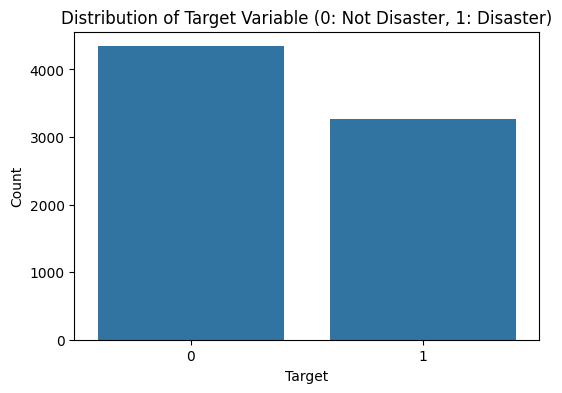

In [58]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=data_filtered)
plt.title('Distribution of Target Variable (0: Not Disaster, 1: Disaster)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


Our visualization confirms that our target column is balanced.

We're now done with data cleaning and we're ready for the text preprocessing.

## Text Preprocessing

Here, we'll do some text preprocessing. This important step turns our text data into something usable in deep learning. Our steps include:

- turning all characters into lowercase,
- removing punctuation and numbers,
- tokenization (turning each word into a unit),
- removing stop words (words that don't contain much semantic importance, such as "the, a, to be" etc),
- lemmatization (turning words into their core meanings, such as removing inflection from verbs),
- joining words back together and creating the "final" column.

In [59]:
# increasing number of chars in the output:
pd.set_option('display.max_colwidth',1000)

In [60]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [61]:
data_filtered['text'] = data_filtered['text'].str.lower()
data_filtered['text'].head(3)

,text
0,our deeds are the reason of this #earthquake may allah forgive us all
1,forest fire near la ronge sask. canada
2,all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected


In [62]:
# removing punctuation and numbers:
def punctuations(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)

data_filtered['text'] = data_filtered['text'].apply(punctuations)
data_filtered['text'].head(3)

,text
0,our deeds are the reason of this earthquake may allah forgive us all
1,forest fire near la ronge sask canada
2,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected


In [63]:
def tokenization(inputs):
    return word_tokenize(inputs)

data_filtered['text_tokenized'] = data_filtered['text'].apply(tokenization)
data_filtered['text_tokenized'].head(3)

,text_tokenized
0,"[our, deeds, are, the, reason, of, this, earthquake, may, allah, forgive, us, all]"
1,"[forest, fire, near, la, ronge, sask, canada]"
2,"[all, residents, asked, to, shelter, in, place, are, being, notified, by, officers, no, other, evacuation, or, shelter, in, place, orders, are, expected]"


In [64]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')

def stopwords_remove(inputs):
    return [k for k in inputs if k not in stop_words]

data_filtered['text_stop'] = data_filtered['text_tokenized'].apply(stopwords_remove)
data_filtered['text_stop'].head(3)

,text_stop
0,"[deeds, reason, earthquake, may, allah, forgive, us]"
1,"[forest, fire, near, la, ronge, sask, canada]"
2,"[residents, asked, shelter, place, notified, officers, evacuation, shelter, place, orders, expected]"


In [65]:
lemmatizer = WordNetLemmatizer()

def lemmatization(inputs):
    return [lemmatizer.lemmatize(word=kk, pos='v') for kk in inputs]

data_filtered['text_lemmatized'] = data_filtered['text_stop'].apply(lemmatization)
data_filtered['text_lemmatized'].head(3)

,text_lemmatized
0,"[deeds, reason, earthquake, may, allah, forgive, us]"
1,"[forest, fire, near, la, ronge, sask, canada]"
2,"[residents, ask, shelter, place, notify, officer, evacuation, shelter, place, order, expect]"


In [66]:
data_filtered['final'] = data_filtered['text_lemmatized'].str.join(' ')
data_filtered['final'].head(3)

,final
0,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada
2,residents ask shelter place notify officer evacuation shelter place order expect


## Visualization with WordCloud

Before starting our deep learning process, let's visualize our corpus. We'll use WordCloud to create an image of words based on their frequency. We'll create two word clouds, one for disaster tweets and another for non-disaster tweets.

In [67]:
data_disaster = data_filtered[data_filtered['target'] == 1]
data_not_disaster = data_filtered[data_filtered['target'] == 0]

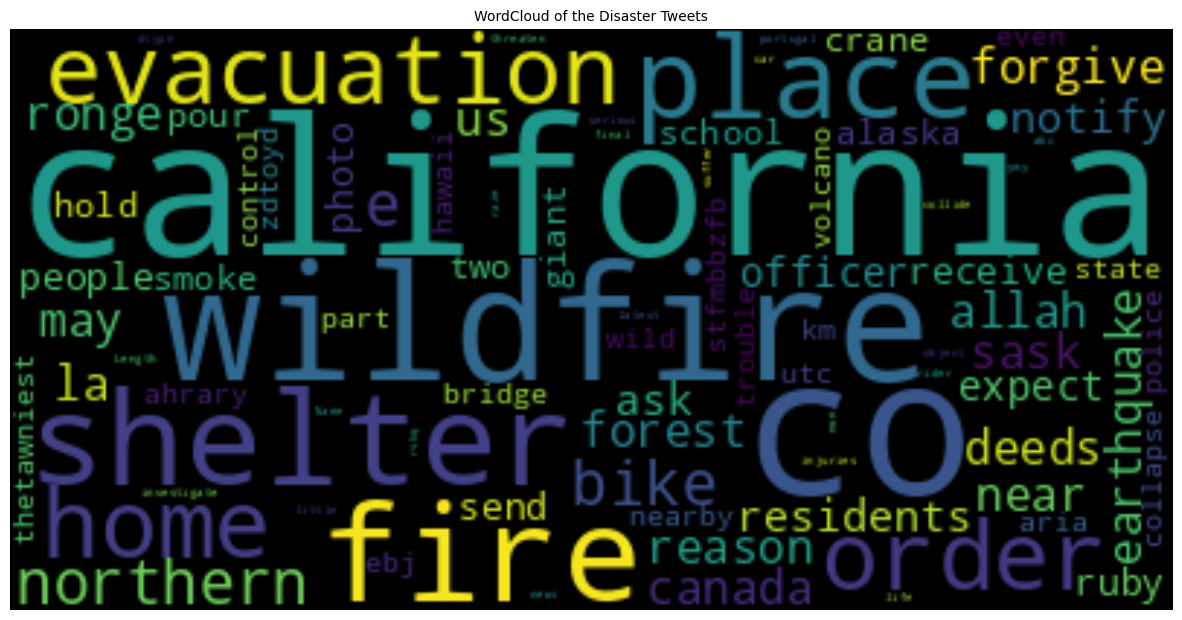

In [68]:
from wordcloud import WordCloud

WordCloud_disaster = WordCloud(max_words=500,
                                  random_state=100,background_color='black',
                                  collocations=True).generate(str((data_disaster['final'])))

plt.figure(figsize=(15, 10))
plt.imshow(WordCloud_disaster, interpolation='bilinear')
plt.title('WordCloud of the Disaster Tweets', fontsize=10)
plt.axis("off")
plt.show()

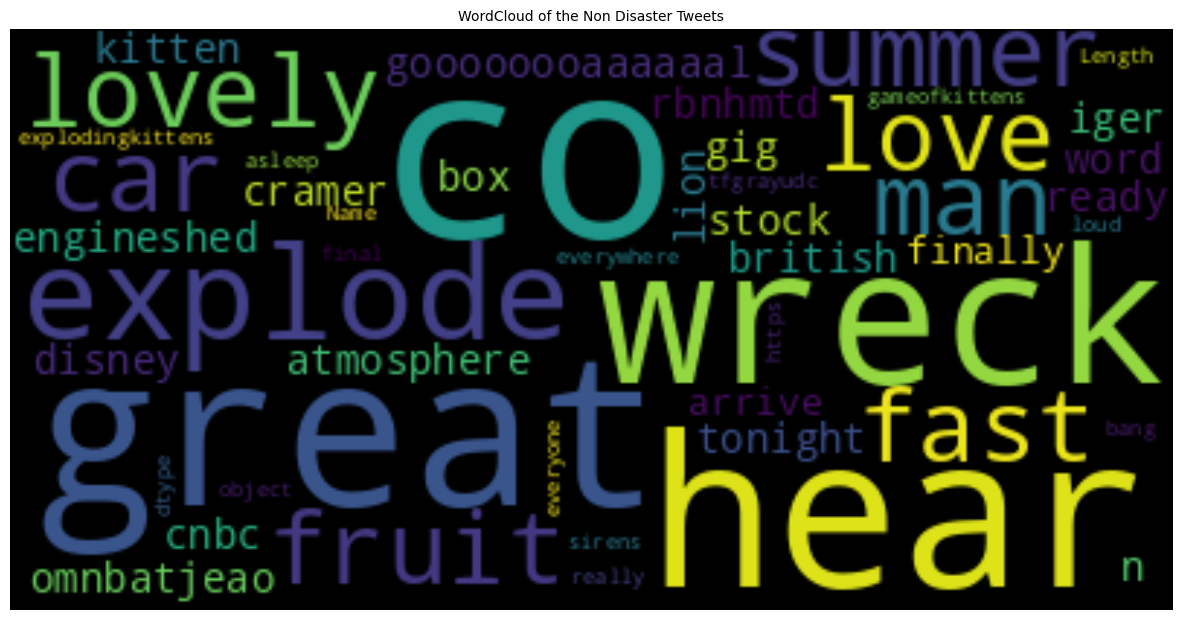

In [69]:
WordCloud_not_disaster = WordCloud(max_words=500,
                                      random_state=100, background_color='black',
                                      collocations=True).generate(str((data_not_disaster['final'])))

plt.figure(figsize=(15, 10))
plt.imshow(WordCloud_not_disaster, interpolation='bilinear')
plt.title('WordCloud of the Non Disaster Tweets', fontsize=10)
plt.axis("off")
plt.show()

Some remarks:
- "California" and "wildfire" are very frequent words in disaster-related tweets, which makes sense in a collection of english tweets about disasters.
- The words "hear" and "explode" are very prevalent in non disaster-related tweets, which could indicate that people mistake smaller explosions such as fireworks or tires with larger ones.

## Building a Shallow Neural Network

It's time to start building our neural networks! We'll first divide our dataset into train and test datasets.

In [70]:
X = data_filtered['final']
y = data_filtered['target']

print(X.head())
print(y.head())

0                                        deeds reason earthquake may allah forgive us
1                                               forest fire near la ronge sask canada
2    residents ask shelter place notify officer evacuation shelter place order expect
3                                people receive wildfires evacuation order california
4                              get send photo ruby alaska smoke wildfires pour school
Name: final, dtype: object
0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64


In [71]:
from sklearn.model_selection import train_test_split

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# printing the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (6090,) (6090,)
Testing set shape: (1523,) (1523,)


In [72]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import TextVectorization

Now, we'll create a vectorizer layer and an embedding layer.

Text vectorization plays a crucial role in NLP, as it allows our model to process, analyze, and interpret unstructured text data. This process involves converting text into numerical vectors, which can then serve as input for deep learning algorithms.

The Embedding layer maps words to a vector of numbers. It takes a sequence of integer-encoded words as input and returns a matrix where each row contains the numerical representation (embedding) of the corresponding word. This numerical representation helps to better capture semantic relationships between words.


In [73]:
max_tokens = 7500
input_length = 128
output_dim = 128

In [74]:
vectorizer_layer = tf.keras.layers.TextVectorization(max_tokens=max_tokens, output_mode='int', standardize='lower_and_strip_punctuation', output_sequence_length=input_length)
vectorizer_layer.adapt(X_train)

In [75]:
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(input_dim=max_tokens,
                            output_dim=output_dim,
                            input_length=input_length)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


And here is our first model. This is a shallow neural network that uses a vectorizer layer and an embedding layer.

In [76]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer),
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, verbose=2)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test set accuracy: {test_acc}")

Epoch 1/10
191/191 - 4s - 22ms/step - accuracy: 0.5697 - loss: 0.6868
Epoch 2/10
191/191 - 1s - 4ms/step - accuracy: 0.5757 - loss: 0.6821
Epoch 3/10
191/191 - 1s - 4ms/step - accuracy: 0.5728 - loss: 0.6793
Epoch 4/10
191/191 - 1s - 4ms/step - accuracy: 0.5847 - loss: 0.6795
Epoch 5/10
191/191 - 1s - 4ms/step - accuracy: 0.5755 - loss: 0.6798
Epoch 6/10
191/191 - 1s - 4ms/step - accuracy: 0.5675 - loss: 0.6824
Epoch 7/10
191/191 - 1s - 7ms/step - accuracy: 0.5786 - loss: 0.6762
Epoch 8/10
191/191 - 2s - 9ms/step - accuracy: 0.5788 - loss: 0.6750
Epoch 9/10
191/191 - 1s - 5ms/step - accuracy: 0.5789 - loss: 0.6760
Epoch 10/10
191/191 - 1s - 4ms/step - accuracy: 0.5746 - loss: 0.6768
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4523 - loss: 0.8325
Test set accuracy: 0.44464051723480225


The accuracy of our shallow neural network is 44%, which is not good at all. In the following sections, we'll be utilizing deep neural networks.

## Building a Multilayer Deep Text Classification Model

In our second model, we'll be using many deep layers. We'll also use dropout layers and kernel regularizer.

A Dropout layer is a smart regularization technique for neural networks that helps to prevent overfitting. It works by randomly turning off (i.e., setting their weights to zero) random neurons during each training iteration. This ingenious trick prevents the nodes from relying too heavily on any particular input feature and helps the model generalize better to unseen data points.

Regularizers add penalties to layer parameters during model optimization. These penalties join forces with the network's loss function, which is then optimized. This penalty discourages the model from assigning overly large weights to any particular feature, helping it generalize better to new unseen data.

We also changed the epoch and optimizer values.

In [77]:
model_regularized = tf.keras.models.Sequential()
model_regularized.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model_regularized.add(vectorizer_layer)
model_regularized.add(embedding_layer)

model_regularized.add(tf.keras.layers.GlobalAveragePooling1D())
model_regularized.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L1(0.0005)))
model_regularized.add(tf.keras.layers.Dropout(0.6))
model_regularized.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=L1L2(0.0005)))
model_regularized.add(tf.keras.layers.Dropout(0.5))
model_regularized.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=L2(0.0005)))
model_regularized.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=L2(0.0005)))
model_regularized.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=L2(0.0005)))
model_regularized.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_regularized.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model_regularized.fit(X_train, y_train, epochs=10, verbose=2)

Epoch 1/10
191/191 - 4s - 23ms/step - accuracy: 0.4741 - loss: 1.6461
Epoch 2/10
191/191 - 1s - 6ms/step - accuracy: 0.5562 - loss: 1.4829
Epoch 3/10
191/191 - 1s - 7ms/step - accuracy: 0.5698 - loss: 1.3484
Epoch 4/10
191/191 - 1s - 7ms/step - accuracy: 0.5739 - loss: 1.2330
Epoch 5/10
191/191 - 1s - 7ms/step - accuracy: 0.5811 - loss: 1.1309
Epoch 6/10
191/191 - 1s - 7ms/step - accuracy: 0.6473 - loss: 1.0252
Epoch 7/10
191/191 - 1s - 6ms/step - accuracy: 0.7585 - loss: 0.8978
Epoch 8/10
191/191 - 1s - 6ms/step - accuracy: 0.8378 - loss: 0.7465
Epoch 9/10
191/191 - 1s - 7ms/step - accuracy: 0.8589 - loss: 0.6723
Epoch 10/10
191/191 - 2s - 12ms/step - accuracy: 0.8693 - loss: 0.6344


In [78]:
test_loss, test_acc = model_regularized.evaluate(X_test, y_test)
print(f"Test set accuracy: {test_acc}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8045 - loss: 0.7494
Test set accuracy: 0.813525915145874


Our accuracy increased to 81%. This is a great increase! But maybe we can do even better.

## Building a Multilayer Bidirectional LSTM Model

We'll now build a multilayer bidirectional LSTM model. Multilayer Bidirectional LSTMs use multiple LSTM layers, enabling the model to gather more context for pattern recognition and prediction making. With multiple LSTM layers, each layer can focus on different aspects of the data and pass on relevant information to the next layer.

In [79]:
ml_bi_lstm = Sequential()
ml_bi_lstm.add(Input(shape=(1,), dtype=tf.string))
ml_bi_lstm.add(vectorizer_layer)
ml_bi_lstm.add(embedding_layer)

ml_bi_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
ml_bi_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
ml_bi_lstm.add(Bidirectional(LSTM(64)))
ml_bi_lstm.add(Dense(64, activation='elu', kernel_regularizer=L1L2(0.0001)))
ml_bi_lstm.add(tf.keras.layers.Dropout(0.6))
ml_bi_lstm.add(Dense(32, activation='elu', kernel_regularizer=L2(0.0001)))
ml_bi_lstm.add(Dense(8, activation='elu', kernel_regularizer=L2(0.0005)))
ml_bi_lstm.add(Dense(8, activation='elu'))
ml_bi_lstm.add(Dense(4, activation='elu'))
ml_bi_lstm.add(Dense(1, activation='sigmoid'))

opt = RMSprop(learning_rate=0.0001, rho=0.8, momentum=0.9)
ml_bi_lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
ml_bi_lstm.fit(X_train, y_train, epochs=10)
test_loss, test_acc = ml_bi_lstm.evaluate(X_test, y_test)
print(f"Test set accuracy: {test_acc}")

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8639 - loss: 0.4386
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8884 - loss: 0.3476
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9051 - loss: 0.3085
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9035 - loss: 0.2979
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9195 - loss: 0.2567
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9173 - loss: 0.2515
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9259 - loss: 0.2215
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9363 - loss: 0.2095
Epoch 9/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9430 - loss: 0.1839
Epoch 10/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9474 - loss: 0.1565
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7766 - loss: 0.5890
Test set accuracy: 0.7813525795936584


Even though our training accuracy increased, our test accuracy seems to have decreased, which indicates that our model may be suffering from overfitting.

## Building a Transformer Model

In this last section, we will use a transformer model. By using attention mechanisms, transformers can focus on relevant parts of the input while disregarding less important sections, making them more efficient and accurate compared to RNNs.

We'll first utilize AutoTokenizer class for tokenization. We'll then use the DistilBERT model. This pre-trained model enables the rapid construction of high-performing models without the need for manual, ground-up training.

In [32]:
# loading the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

# tokenizing the text data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# creating TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.constant(y_train.values, dtype=tf.int32)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf.constant(y_test.values, dtype=tf.int32)
))

train_dataset = train_dataset.batch(16)
test_dataset = test_dataset.batch(16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [41]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

optimizer=tf.keras.optimizers.Adam(learning_rate=6e-6)

loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

import tensorflow.compat.v1 as tf

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=6e-6),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [42]:
model.fit(train_dataset, epochs=5, validation_data=train_dataset)

Epoch 1/5
381/381 [==============================] - 56s 125ms/step - loss: 0.5020 - accuracy: 0.7752 - val_loss: 0.4039 - val_accuracy: 0.8273
Epoch 2/5
381/381 [==============================] - 46s 121ms/step - loss: 0.3945 - accuracy: 0.8379 - val_loss: 0.3549 - val_accuracy: 0.8594
Epoch 3/5
381/381 [==============================] - 46s 121ms/step - loss: 0.3493 - accuracy: 0.8632 - val_loss: 0.3124 - val_accuracy: 0.8775
Epoch 4/5
381/381 [==============================] - 46s 122ms/step - loss: 0.2995 - accuracy: 0.8869 - val_loss: 0.2509 - val_accuracy: 0.9136
Epoch 5/5
381/381 [==============================] - 46s 121ms/step - loss: 0.2573 - accuracy: 0.9079 - val_loss: 0.1913 - val_accuracy: 0.9379


In [43]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test set accuracy: {test_acc}")

96/96 [==============================] - 5s 31ms/step - loss: 0.4339 - accuracy: 0.8247
Test set accuracy: 0.8246881365776062


Our accuracy has risen to 82%. This is an improvement over our Multilayer Deep Text Classification Model, albeit not by much.

## Conclusion

After some text preprocessing, we created a WordCloud visualization using a dataset of tweets related to disasters. We then employed shallow and deep neural networks to classify the tweets as related or not related to disasters. We lastly created a transformer model with DistilBERT, obtaining the highest accuracy. Further hyperparameter tuning may increase this accuracy even further.